# Нелинейное снижение размерности методом Isomap

![isomap](pictures/intro.jpg)

### Багаев Д.В.

Non-linear dimensionality reduction
* Based on assumption that original data $x \in R^D $ is distributed compactly on non-linear surface with dimensionality $d < D$
* Let $ y \in R^d $ denote the coordinates of $x$ on the surface
* Sample dataset:
![isomap](pictures/s.jpg)
* Linear dimensionality reduction techniques will fail here

In [68]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

class RowImages():
    def __init__(self, images, columns = 5, size = (20, 10)):
        self.images = images
        self.columns = columns
        self.size = size
        
    def show(self):
        images = []
        for img_path in map(lambda x: x[0], self.images):
            images.append(mpimg.imread(img_path))

        plt.figure(figsize=self.size)
        titles = list(map(lambda x: x[1], self.images))
        for i, image in enumerate(images):
            subplot = plt.subplot(len(images) / self.columns + 1, self.columns, i + 1)
            subplot.set_title(titles[i])
            _ = plt.imshow(image)

In [69]:
typicalDatasetsImages = [
    ('pictures/isomap-graph.png', ''), 
    ('pictures/swiss-roll.png', 'Swiss roll dataset'), 
    ('pictures/helix.png', 'Helix dataset'),
    ('pictures/twinpeaks.png', 'Twinpeaks dataset'),
    ('pictures/broken-swiss.png', 'Broken Swiss dataset')
]

typicalDatasets = RowImages(typicalDatasetsImages, columns = 3)

Typical datasets for dimensionality reduction evaluation


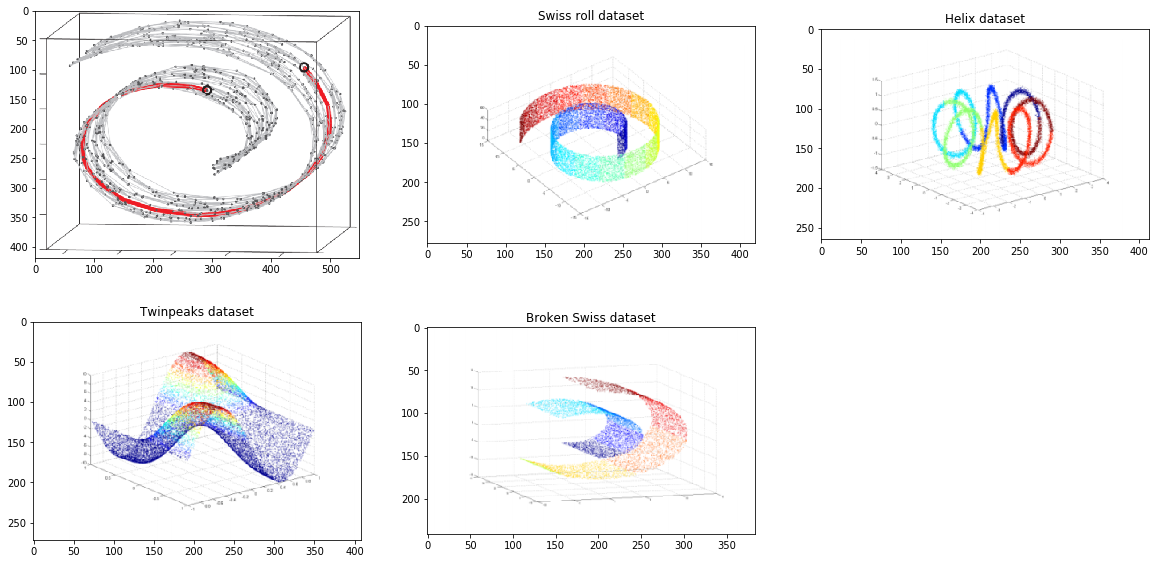

In [70]:
print("Typical datasets for dimensionality reduction evaluation")
typicalDatasets.show()

** Comment **: True datasets have much more dimensions, more complex structure, errors, outliers etc.

## Analysis
![Issue](pictures/issue.png)
**Issue**: small $||x_i - x_j||$ should not always imply small $||y_i - y_j||$

## Solution
** Isomap **: Map $x \Rightarrow y$ preserving correspondence beetwen distance in target space and geodesic distance along the surface in original space.
![Solution](pictures/solution.png)

## Isomap

** Algorithm **:
* Geodesic distance calculation:
    * for each $x_n$ find its $K$ nearest neighbours
    * build the pairwise distance matrix, filling distance beetwen samples and their nearest neighbours
    * calculate all pairwise distances using shortest-path algorithm of Dijkstra or Floyd
* Apply MDS to match $||x_i - x_j||_G$ and $||y_i - y_j||$, where $||\cdot||_G$ is geodesic distance.

## Issues of Isomap

* Noisy observations beetwen distant parts of surfaces may make distant parts close
* Solutions
    * remove observations with large total flows through them
    * remove nearest neighbours that vilate local linaerity
* Selection of $K$
    * if too small, then poor approximation of geodesic distance
    * if too large, then increases chance of "short-circuiting" through noisy observations.